In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns

In [4]:
df = pd.read_parquet('./datasets/bechdel_ratings.parquet')
df = df.rename(columns={'rating': 'bechdel_rating'})
df.to_parquet('./datasets/bechdel_ratings.parquet', index=False)

In [30]:
ratings_df = pd.read_parquet('./datasets/avg_ratings.parquet')

df['imdb_id'] = df['imdb_id'].astype(str)
ratings_df['imdb_id'] = ratings_df['imdb_id'].astype(str).str.zfill(7)

movies_w_ratings = ratings_df.merge(df[["imdb_id", "bechdel_rating"]], on="imdb_id", how="left")
#print(movies_w_ratings.head(50))

In [28]:
passing_movies = movies_w_ratings[movies_w_ratings['bechdel_rating'] >= 3]
failing_movies = movies_w_ratings[movies_w_ratings['bechdel_rating'] < 3]

print("Summary stats of passing movies")
print("mean:", np.mean(passing_movies["rating"]))
print("median:", np.median(passing_movies["rating"]))
print("mode:", passing_movies["rating"].mode()[0])
print("std deviation:", np.std(passing_movies["rating"]))

print(" ")
print("Summary stats of failing movies")
print("mean:", np.mean(failing_movies["rating"]))
print("median:", np.median(failing_movies["rating"]))
print("mode:", failing_movies["rating"].mode()[0])
print("std deviation:", np.std(failing_movies["rating"]))

Summary stats of passing movies
mean: 3.2492940652732845
median: 3.325911875250389
mode: 3.5
std deviation: 0.5242898415372204
 
Summary stats of failing movies
mean: 3.308254439030753
median: 3.375
mode: 3.0
std deviation: 0.5340383804647884


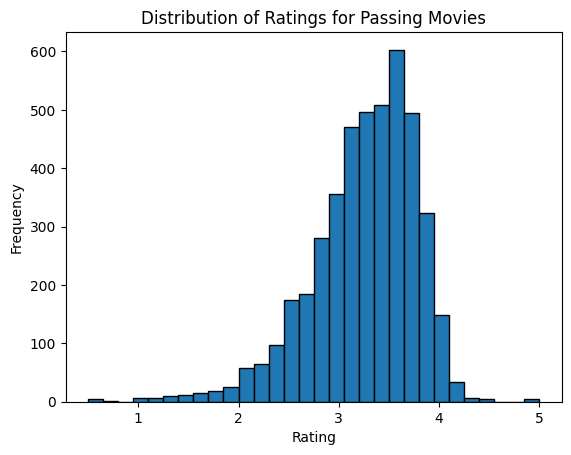

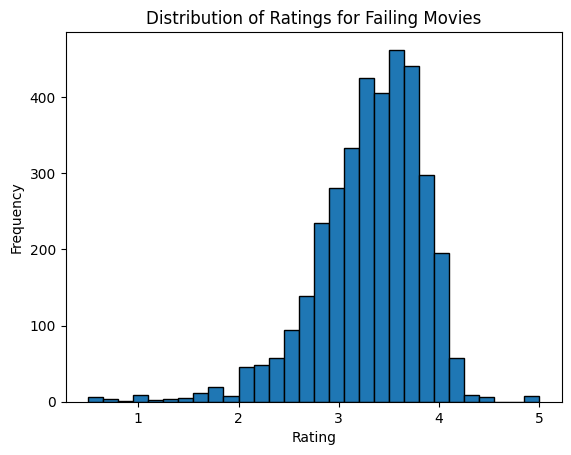

In [29]:
passing_movies['rating'].plot(kind='hist', bins=30, edgecolor='black')

plt.title('Distribution of Ratings for Passing Movies')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

failing_movies['rating'].plot(kind='hist', bins=30, edgecolor='black')

plt.title('Distribution of Ratings for Failing Movies')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

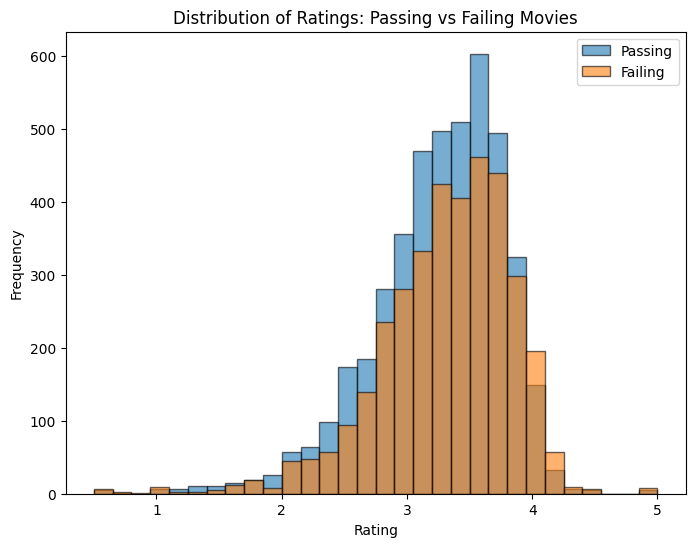

In [ ]:


plt.figure(figsize=(8,6))

plt.hist(passing_movies['rating'], bins=30, alpha=0.6, edgecolor='black', label='Passing')
plt.hist(failing_movies['rating'], bins=30, alpha=0.6, edgecolor='black', label='Failing')

plt.title('Distribution of Ratings: Passing vs Failing Movies')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()
#plt.savefig(f"./figures/ratings_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


In [32]:
genres_df = pd.read_parquet('./datasets/genres.parquet')

genres_df["imdb_id"] = genres_df["imdb_id"].astype(str).str.replace("^tt", "", regex=True).str.strip()

df['imdb_id'] = df['imdb_id'].astype(str)
genres_df['imdb_id'] = genres_df['imdb_id'].astype(str).str.zfill(7)

movies_w_genres = genres_df.merge(df[["imdb_id", "bechdel_rating"]], on="imdb_id", how="left")
#print(movies_w_genres.head(50))

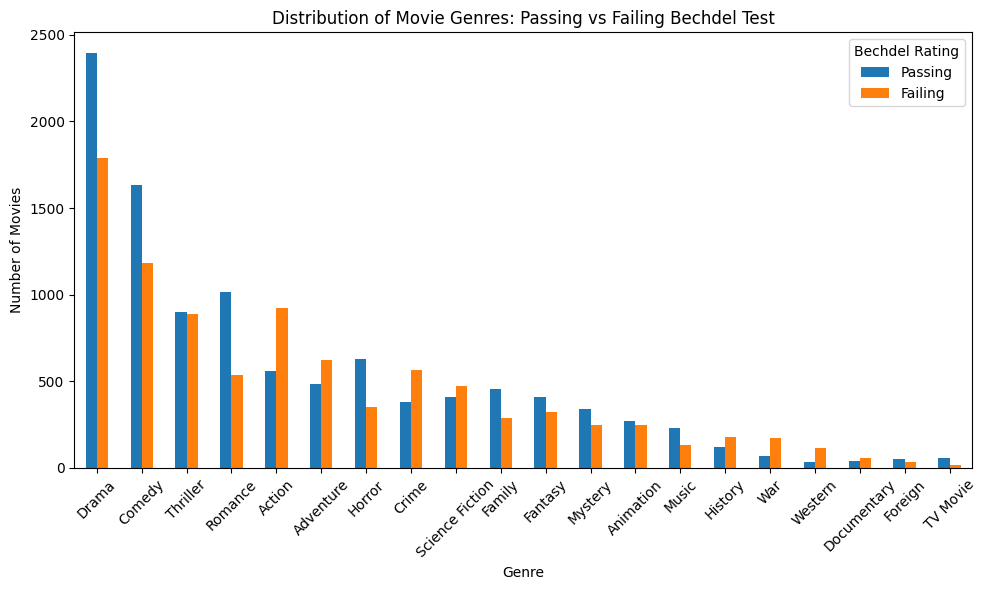

In [ ]:
passing_movies_genres = movies_w_genres[movies_w_genres['bechdel_rating'] >= 3]
failing_movies_genres = movies_w_genres[movies_w_genres['bechdel_rating'] < 3]


passing_counts = passing_movies_genres['genre'].value_counts()
failing_counts = failing_movies_genres['genre'].value_counts()


genre_df = pd.DataFrame({
    'Passing': passing_counts,
    'Failing': failing_counts
})

genre_df = genre_df.loc[genre_df.sum(axis=1).sort_values(ascending=False).index]


genre_df.plot(kind='bar', figsize=(10, 6))

plt.title('Distribution of Movie Genres: Passing vs Failing Bechdel Test')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.legend(title='Bechdel Rating')
plt.tight_layout()
#plt.savefig(f"./figures/genres_distribution.png", dpi=300, bbox_inches="tight")
plt.show()




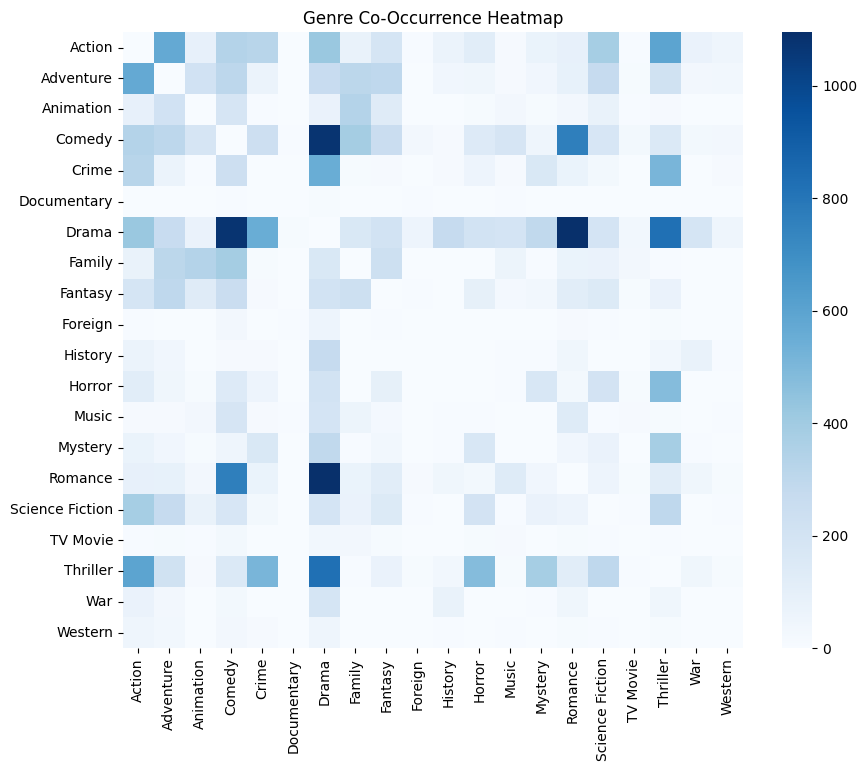

In [ ]:
movies_grouped = movies_w_genres.groupby('movie_id')['genre'].apply(set)
genres = sorted(movies_w_genres['genre'].unique())

co_matrix = pd.DataFrame(0, index=genres, columns=genres)

for genre_set in movies_grouped:
    for g1, g2 in combinations(genre_set, 2):
        co_matrix.loc[g1, g2] += 1
        co_matrix.loc[g2, g1] += 1

plt.figure(figsize=(10,8))
sns.heatmap(co_matrix, cmap='Blues')
plt.title('Genre Co-Occurrence Heatmap')
plt.show()


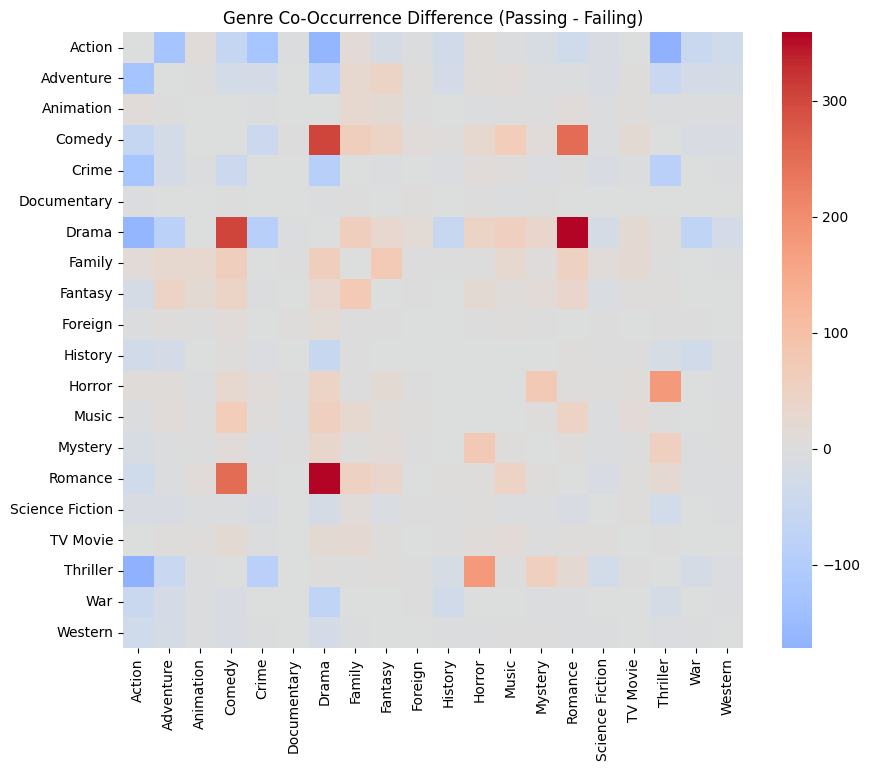

In [ ]:
def make_co_matrix(df):
    movies_grouped = df.groupby('movie_id')['genre'].apply(set)
    genres = sorted(df['genre'].unique())
    co_matrix = pd.DataFrame(0, index=genres, columns=genres)
    for genre_set in movies_grouped:
        for g1, g2 in combinations(genre_set, 2):
            co_matrix.loc[g1, g2] += 1
            co_matrix.loc[g2, g1] += 1
    return co_matrix

passing = movies_w_genres[movies_w_genres['bechdel_rating'] >= 3]
failing = movies_w_genres[movies_w_genres['bechdel_rating'] < 3]

co_pass = make_co_matrix(passing)
co_fail = make_co_matrix(failing)

diff_matrix = co_pass - co_fail

plt.figure(figsize=(10,8))
sns.heatmap(diff_matrix, cmap='coolwarm', center=0)
plt.title('Genre Co-Occurrence Difference (Passing - Failing)')
#plt.savefig(f"./figures/genres_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()